Práctica realizada por Jaime Álvarez Urueña y Alejandro Mendoza Medina (equipo Soft_Gonzalo)

# Cargar el dataset

In [2]:
import json
import torch
import os.path as osp
from torch_geometric.data import InMemoryDataset, download_url
from torch_geometric.nn import MLP,MessagePassing
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, MLP
from torch import nn
import torch
from torch_geometric.nn import MessagePassing, MLP
from torch_geometric.nn import MLP
from torch.nn import Linear


class TournamentDataset(InMemoryDataset):

    TORUNAMENT_URL = 'https://drive.upm.es/s/mnsESjBucKUKsEg/download'

    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['tournament.pt']

    @property
    def processed_file_names(self):
        return ['tournament.pt']

    @property
    def num_classes(self):
        return 3

    @property
    def num_features(self):
        return 500

    def download(self):
        download_url(self.TORUNAMENT_URL, self.raw_dir, filename='tournament.pt')

    def process(self):
        data_list = [torch.load(osp.join(self.raw_dir, 'tournament.pt'))]

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])

    def create_test_json(self, model, file_path, device="cpu"):
        data = self[0]

        model = model.to(device)
        data = data.to(device)

        model.eval()
        out = model(data.x, data.edge_index)
        y_pred = out[data.test_mask].argmax(dim=1)
        nid = data.nid[data.test_mask]

        pred = {
            'nid': nid.detach().cpu().numpy().tolist(),
            'y': y_pred.detach().cpu().numpy().tolist()
        }

        with open(file_path, 'w') as f:
            json.dump(pred, f)


In [3]:
dataset = TournamentDataset("tournament")
data = dataset[0]
vals=[]
tests=[]

# Definir todos los modelos

# Agregador universal
$\text{MLP}_{\theta} \left( \sum_{v \in N(u)} \text{MLP}_{\phi} \left( z_v^{l-1} \right) \right)$

* **MSG**: $m_u^l = \text{MLP}_{\phi} \left( z_v^{l-1} \right) $
* **AGG**: $a_u^l = \sum_{v \in N(u)} m_v^l$ 
* **UPDATE**: $z_u^l = \text{MLP}_{\theta} \left( a_v^{l} \right)$

In [4]:
from torch_geometric.nn import MessagePassing, MLP

class UniversalAggregatorConv(MessagePassing):
    def __init__(self, in_channels, out_channels, hidden_channels, num_layers):
        super(UniversalAggregatorConv, self).__init__(aggr='sum')
        
        self.MLP_phi = MLP(
            in_channels=in_channels, 
            out_channels=out_channels,
            hidden_channels=hidden_channels, 
            num_layers=num_layers
        )
        self.MLP_theta = MLP(
            in_channels=out_channels, 
            out_channels=out_channels,
            hidden_channels=hidden_channels, 
            num_layers=num_layers
        )

        self.reset_parameters()

    def reset_parameters(self):
        self.MLP_phi.reset_parameters()
        self.MLP_theta.reset_parameters()

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)
    
    def message(self, x_j):
        return self.MLP_phi(x_j)
    
    def update(self, aggr_out):
        return self.MLP_theta(aggr_out)
class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = UniversalAggregatorConv(node_features, hidden_channels, 32, 2)
        self.conv2 = UniversalAggregatorConv(hidden_channels, hidden_channels, 32, 2)
        self.cls = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.cls(x)
        return x
model = GCN(dataset.num_node_features, 512, dataset.num_classes)

# Entrenar el modelo

In [5]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam,AdamW
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from torch_geometric.loader import NeighborLoader
best=0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
optm_func = CrossEntropyLoss()

data = data.to(device)
NeighborLoader()
neis = [25, 10]
train_loader = NeighborLoader(data, batch_size=256, num_neighbors=neis, input_nodes=data.train_mask, shuffle=True)
for epoch in range(300):
    model.train()
    for batch in train_loader:
            batch = batch.to(device)
            batch_size = batch.batch_size
            optimizer.zero_grad()
            out = model(batch.x,batch.edge_index)
            loss = optm_func(out[:batch_size], batch.y[:batch_size])
            loss.backward()
            optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1)[data.val_mask].detach().cpu()
    y = data.y.argmax(dim=1)[data.val_mask].detach().cpu()
    score=f1_score(y, y_pred, average='micro')
    if score>=best:
        best=score
        checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }
        torch.save(checkpoint, 'best_model_universal.pth')


Epoch 0: Loss 0.7496140599250793
Epoch 50: Loss 0.3818674683570862
Epoch 100: Loss 0.25526389479637146
Epoch 150: Loss 0.2594338059425354
Epoch 200: Loss 0.22320888936519623
Epoch 250: Loss 0.32177215814590454


# Validación

F1 score: 0.8495774647887324


/tmp/ipykernel_33717/938377067.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint=torch.load(checkpoint_path)


<Axes: >

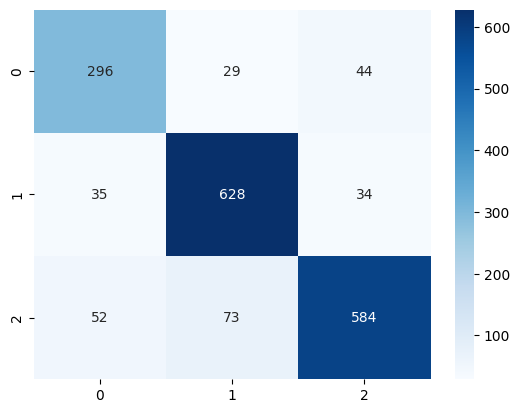

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
import pandas as pd
device='cuda'
data=data.to(device)
model.eval()
checkpoint_path = "best_model_universal.pth"
# checkpoint_path = "t5_checkpoint.pth"
checkpoint=torch.load(checkpoint_path)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
out = model(data.x, data.edge_index)
y_pred = out.argmax(dim=1)[data.val_mask].detach().cpu()
y = data.y.argmax(dim=1)[data.val_mask].detach().cpu()
result=f1_score(y, y_pred, average='micro')
vals.append(result)
print(f"F1 score: {result}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')
# dataset.create_test_json(model, 'pred_labels.json', device=device)

F1 score: 0.802738336713996


<Axes: >

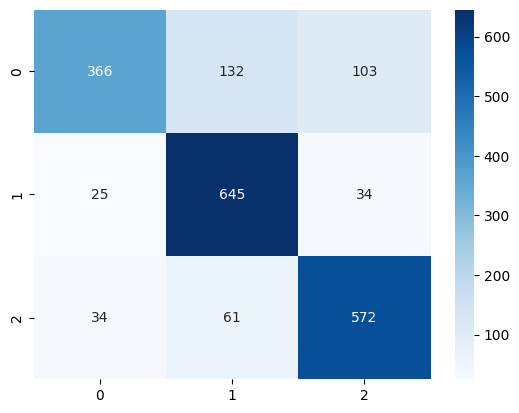

In [7]:
df=pd.read_csv('test_labels.csv')

id=np.array(df['nid'])

y_pred = out.argmax(dim=1)[id].to(device).detach().cpu()
y = data.y.argmax(dim=1)[id].detach().cpu()

result=f1_score(y, y_pred, average='micro')
tests.append(result)
print(f"F1 score: {result}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')



## GRU skip connection layer

$ z_i^l = \text{GRU}(W_{\phi}^l \sum_{j \in \mathcal{N}(i)} z_j^{l-1}, z_i^{t-1}) $

* **MSG**: $m_u^l = W_\phi^lz^{l-1}_u $
* **AGG**: $a_u^l = \sum_{v \in N(u)} m_v^l$ 
* **UPDATE**: $z_u^l = \text{GRU}(a_u^l, z_u^{l-1}) $

In [8]:
class UpdateGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        """
        Custom GRU based on the given equations.
        
        Args:
            input_dim (int): Dimension of the input vector x.
            hidden_dim (int): Dimension of the hidden state h.
        """
        super(UpdateGRU, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Input-to-hidden weights and biases
        self.W_ir = nn.Linear(input_dim, hidden_dim, bias=True)
        self.W_iz = nn.Linear(input_dim, hidden_dim, bias=True)
        self.W_in = nn.Linear(input_dim, hidden_dim, bias=True)
        
        # Hidden-to-hidden weights and biases
        self.W_hr = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.W_hz = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.W_hn = nn.Linear(hidden_dim, hidden_dim, bias=True)
        
        # Activation functions
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def reset_parameters(self):
        self.W_ir.reset_parameters()
        self.W_iz.reset_parameters()
        self.W_in.reset_parameters()
        self.W_hr.reset_parameters()
        self.W_hz.reset_parameters()
        self.W_hn.reset_parameters

    def forward(self, x_t, h_t_minus_1):
        """
        Forward pass for a single time step.
        
        Args:
            x_t (torch.Tensor): Input vector at time t, shape (batch_size, input_dim).
            h_t_minus_1 (torch.Tensor): Hidden state at time t-1, shape (batch_size, hidden_dim).
        
        Returns:
            h_t (torch.Tensor): Updated hidden state at time t, shape (batch_size, hidden_dim).
        """
        # Compute reset gate
        r_t = self.sigmoid(self.W_ir(x_t) + self.W_hr(h_t_minus_1))
        
        # Compute update gate
        z_t = self.sigmoid(self.W_iz(x_t) + self.W_hz(h_t_minus_1))
        
        # Compute candidate hidden state
        n_t = self.tanh(self.W_in(x_t) + r_t * self.W_hn(h_t_minus_1))
        
        # Compute new hidden state
        h_t = (1 - z_t) * n_t + z_t * h_t_minus_1
        
        return h_t

class GRUConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GRUConv, self).__init__(aggr='sum')

        self.W_phi = Linear(in_channels, out_channels, bias=True)
        self.gru = UpdateGRU(in_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_phi.reset_parameters()
        self.gru.reset_parameters()

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x, central_node=x)
    
    def message(self, x_j):
        return self.W_phi(x_j)
    
    def update(self, aggr_out, central_node):
        return self.gru(central_node, aggr_out)
class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GRUConv(node_features, hidden_channels)
        self.conv2 = GRUConv(hidden_channels, hidden_channels)
        self.cls = MLP(in_channels=hidden_channels, out_channels=num_classes, num_layers=2, hidden_channels=hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.cls(x)
        return x
model = GCN(dataset.num_node_features, 512, dataset.num_classes)


# Entrenar el modelo

In [9]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam,AdamW
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
# for i in range(len(data.train_mask)):
#     data.train_mask[i]=True
best=0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
optm_func = CrossEntropyLoss()

data = data.to(device)

neis = [25, 10]
train_loader = NeighborLoader(data, batch_size=256, num_neighbors=neis, input_nodes=data.train_mask, shuffle=True   )
for epoch in range(300):
    model.train()
    for batch in train_loader:
            batch = batch.to(device)
            batch_size = batch.batch_size
            optimizer.zero_grad()
            out = model(batch.x,batch.edge_index)
            loss = optm_func(out[:batch_size], batch.y[:batch_size])
            loss.backward()
            optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1)[data.val_mask].detach().cpu()
    y = data.y.argmax(dim=1)[data.val_mask].detach().cpu()
    score=f1_score(y, y_pred, average='micro')
    if score>=best:
        best=score
        checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }
        torch.save(checkpoint, 'best_model_gru_skip.pth')


Epoch 0: Loss 0.5520500540733337
Epoch 50: Loss 0.016132621094584465
Epoch 100: Loss 0.010491901077330112
Epoch 150: Loss 0.0005767217953689396
Epoch 200: Loss 0.00030535898986272514
Epoch 250: Loss 0.0006266202544793487


# Validación

/tmp/ipykernel_33717/538945030.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint=torch.load(checkpoint_path)


F1 score: 0.8985915492957747


<Axes: >

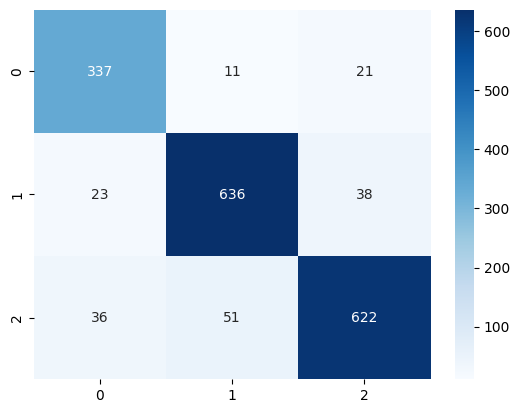

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
import pandas as pd
device='cuda'
data=data.to(device)
model.eval()
checkpoint_path = "best_model_gru_skip.pth"
# checkpoint_path = "t5_checkpoint.pth"
checkpoint=torch.load(checkpoint_path)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
out = model(data.x, data.edge_index)
y_pred = out.argmax(dim=1)[data.val_mask].detach().cpu()
y = data.y.argmax(dim=1)[data.val_mask].detach().cpu()
result=f1_score(y, y_pred, average='micro')
vals.append(result)
print(f"F1 score: {result}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')
# dataset.create_test_json(model, 'pred_labels.json', device=device)

F1 score: 0.8980730223123732


<Axes: >

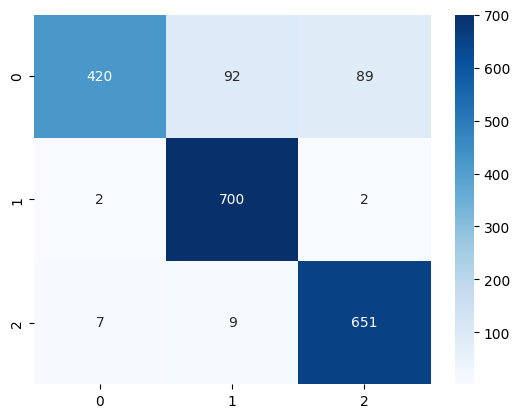

In [11]:
df=pd.read_csv('test_labels.csv')

id=np.array(df['nid'])

y_pred = out.argmax(dim=1)[id].to(device).detach().cpu()
y = data.y.argmax(dim=1)[id].detach().cpu()

result=f1_score(y, y_pred, average='micro')
tests.append(result)
print(f"F1 score: {result}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')



# Graph Attention

Implementación disponible en [pytroch_geometric](https://pytorch-geometric.readthedocs.io/en/stable/generated/torch_geometric.nn.conv.GATConv.html#torch_geometric.nn.conv.GATConv)

$ \sum_{v \in \mathcal{N}(u)}{\frac{\exp(\text{MLP}_{\phi}( W^l x_u^{l-1} \oplus  W^l x_v^{l-1})}{\sum_{j' \in \mathcal{N}(i)} \exp(\text{MLP}_{\phi}( W^l x_u^{l-1} \oplus  W^l x_{v'}^{l-1}))}} $

* **MSG**: $ m_u^l = W^l x_u^{l-1} $
* **AGG**: $ a_u^l = \sum_{v \in \mathcal{N}(u)}{\frac{\exp(\text{MLP}_{\phi}(\mathbf{m}_u^{l-1} \oplus \mathbf{m}_v^{l-1}))}{\sum_{j' \in \mathcal{N}(i)} \exp(\text{MLP}_{\phi}(\mathbf{m}_u^{l-1} \oplus \mathbf{z}_{v'}^{l-1}))}} $
* **UPDATE**: $ z_u^l = a_u^l $

In [12]:
import torch
from torch_geometric.nn import MessagePassing, MLP
from torch_geometric.utils import add_self_loops, softmax

class CustomGATConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGATConv, self).__init__(aggr='sum')
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.mlp_phi = MLP(
            in_channels=2*out_channels,
            out_channels=1,
            hidden_channels=16,
            num_layers=1
        )

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.mlp_phi.reset_parameters()

    def forward(self, x, edge_index):
        # Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Linearly transform node feature matrix.
        z = self.lin(x)

        # Start propagating messages.
        return self.propagate(edge_index, size=(z.size(0), z.size(0)), x=z)

    def message(self, edge_index_i, x_i, x_j, size_i):
        # Compute attention coefficients.
        x_ij = torch.cat([x_i, x_j], dim=1)
        alpha = self.mlp_phi(x_ij)
        alpha = softmax(alpha, edge_index_i, num_nodes=size_i)

        return alpha * x_j

    def update(self, aggr_out):

        # aggr_out has shape [N, out_channels]

        # Return new node embeddings.
        return aggr_out
class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = CustomGATConv(node_features, hidden_channels)
        self.conv2 = CustomGATConv(hidden_channels, hidden_channels)
        self.cls = MLP(in_channels=hidden_channels, out_channels=num_classes, num_layers=2, hidden_channels=hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.cls(x)
        return x
model = GCN(dataset.num_node_features, 512, dataset.num_classes)


# Entrenar el modelo

In [13]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam,AdamW
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
# for i in range(len(data.train_mask)):
#     data.train_mask[i]=True
best=0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
optm_func = CrossEntropyLoss()

data = data.to(device)


neis = [25, 10]
train_loader = NeighborLoader(data, batch_size=256, num_neighbors=neis, input_nodes=data.train_mask, shuffle=True)
for epoch in range(300):
    model.train()
    for batch in train_loader:
            batch = batch.to(device)
            batch_size = batch.batch_size
            optimizer.zero_grad()
            out = model(batch.x,batch.edge_index)
            loss = optm_func(out[:batch_size], batch.y[:batch_size])
            loss.backward()
            optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1)[data.val_mask].detach().cpu()
    y = data.y.argmax(dim=1)[data.val_mask].detach().cpu()
    score=f1_score(y, y_pred, average='micro')
    if score>=best:
        best=score
        checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }
        torch.save(checkpoint, 'best_model_attention.pth')


Epoch 0: Loss 0.506323516368866
Epoch 50: Loss 0.02427666448056698
Epoch 100: Loss 0.014986604452133179
Epoch 150: Loss 0.006156723015010357
Epoch 200: Loss 0.06769344955682755
Epoch 250: Loss 0.046925172209739685


# Validación

F1 score: 0.8811267605633802


/tmp/ipykernel_33717/838540344.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint=torch.load(checkpoint_path)


<Axes: >

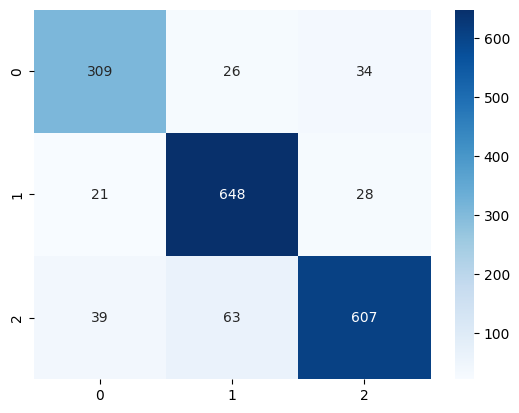

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
import pandas as pd
device='cuda'
data=data.to(device)
model.eval()
checkpoint_path = "best_model_attention.pth"
# checkpoint_path = "t5_checkpoint.pth"
checkpoint=torch.load(checkpoint_path)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
out = model(data.x, data.edge_index)
y_pred = out.argmax(dim=1)[data.val_mask].detach().cpu()
y = data.y.argmax(dim=1)[data.val_mask].detach().cpu()
result=f1_score(y, y_pred, average='micro')
vals.append(result)
print(f"F1 score: {result}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')
# dataset.create_test_json(model, 'pred_labels.json', device=device)

F1 score: 0.8341784989858012


<Axes: >

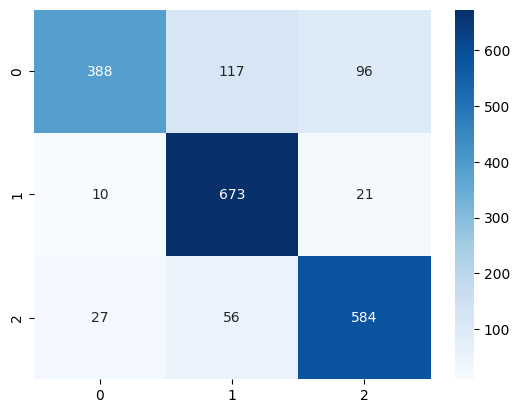

In [15]:
df=pd.read_csv('test_labels.csv')

id=np.array(df['nid'])

y_pred = out.argmax(dim=1)[id].to(device).detach().cpu()
y = data.y.argmax(dim=1)[id].detach().cpu()

result=f1_score(y, y_pred, average='micro')
tests.append(result)
print(f"F1 score: {result}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')



# Concat skip connections

$ \mathbf{z}_i^{l} = W_{\theta}^l (z_i^{l-1} \oplus (W_{\phi}^l \sum_{j \in \mathcal{N}(i)} z_j^{l-1})) \ $

* **MSG**: $m_u^l = W_\phi^lz^{l-1}_u $
* **AGG**: $a_u^l = \sum_{v \in N(u)} m_v^l$ 
* **UPDATE**: $z_u^l = W_{\theta}^l (z_i^{l-1} \oplus a_u^l)$

In [16]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing

class SkipConcatConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(SkipConcatConv, self).__init__(aggr='sum')
        
        self.W_theta = Linear(in_channels + out_channels, out_channels)
        self.b_theta = Parameter(torch.Tensor(out_channels))

        self.W_phi = Linear(in_channels, out_channels)
        self.b_phi = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.W_theta.reset_parameters()
        self.b_theta.data.zero_()
        self.W_phi.reset_parameters()
        self.b_phi.data.zero_()

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x, central_node=x)
    
    def message(self, x_j):
        return self.W_phi(x_j) + self.b_phi
    
    def update(self, aggr_out, central_node):
        a = torch.concat([central_node, aggr_out], dim=1)
        return self.W_theta(a) + self.b_theta
class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = SkipConcatConv(node_features, hidden_channels)
        self.conv2 = SkipConcatConv(hidden_channels, hidden_channels)
        self.cls = MLP(in_channels=hidden_channels, out_channels=num_classes, num_layers=2, hidden_channels=hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.cls(x)
        return x
model = GCN(dataset.num_node_features, 512, dataset.num_classes)

# Entrenar el modelo

In [17]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam,AdamW
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
# for i in range(len(data.train_mask)):
#     data.train_mask[i]=True
best=0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
optm_func = CrossEntropyLoss()

data = data.to(device)


neis = [25, 10]
train_loader = NeighborLoader(data, batch_size=256, num_neighbors=neis, input_nodes=data.train_mask, shuffle=True)
for epoch in range(300):
    model.train()
    for batch in train_loader:
            batch = batch.to(device)
            batch_size = batch.batch_size
            optimizer.zero_grad()
            out = model(batch.x,batch.edge_index)
            loss = optm_func(out[:batch_size], batch.y[:batch_size])
            loss.backward()
            optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1)[data.val_mask].detach().cpu()
    y = data.y.argmax(dim=1)[data.val_mask].detach().cpu()
    score=f1_score(y, y_pred, average='micro')
    if score>=best:
        best=score
        checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }
        torch.save(checkpoint, 'best_model_concat.pth')


Epoch 0: Loss 0.4870617687702179
Epoch 50: Loss 0.046127624809741974
Epoch 100: Loss 0.03852478042244911
Epoch 150: Loss 0.0025897473096847534
Epoch 200: Loss 0.0008328395779244602
Epoch 250: Loss 0.0171908438205719


# Validación

F1 score: 0.8985915492957747


/tmp/ipykernel_33717/2549709236.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint=torch.load(checkpoint_path)


<Axes: >

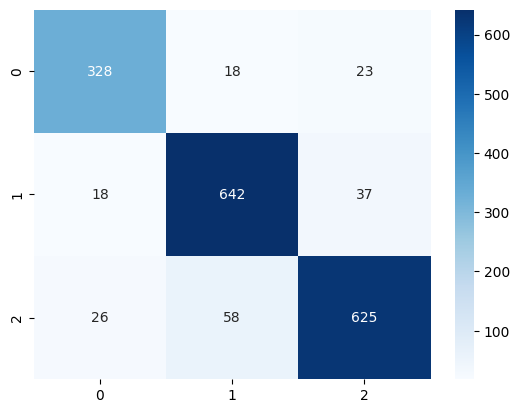

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
import pandas as pd
device='cuda'
data=data.to(device)
model.eval()
checkpoint_path = "best_model_concat.pth"
# checkpoint_path = "t5_checkpoint.pth"
checkpoint=torch.load(checkpoint_path)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
out = model(data.x, data.edge_index)
y_pred = out.argmax(dim=1)[data.val_mask].detach().cpu()
y = data.y.argmax(dim=1)[data.val_mask].detach().cpu()
result=f1_score(y, y_pred, average='micro')
vals.append(result)
print(f"F1 score: {result}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')
# dataset.create_test_json(model, 'pred_labels.json', device=device)

F1 score: 0.8980730223123732


<Axes: >

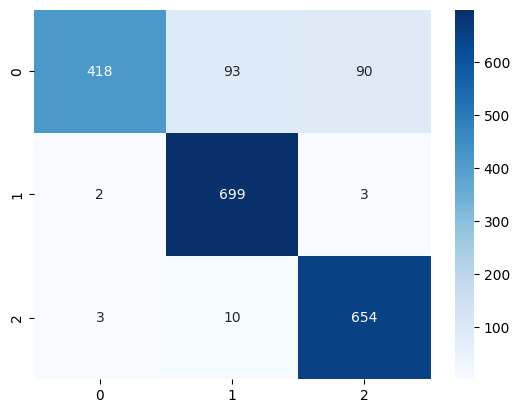

In [19]:
df=pd.read_csv('test_labels.csv')

id=np.array(df['nid'])

y_pred = out.argmax(dim=1)[id].to(device).detach().cpu()
y = data.y.argmax(dim=1)[id].detach().cpu()

result=f1_score(y, y_pred, average='micro')
tests.append(result)
print(f"F1 score: {result}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')



# Interpolate skip connection

$ \mathbf{z}_i^{l} =\alpha^l \odot (W_{\theta}^l z_i^{l-1}) + (1-\alpha^l ) \odot (W_{\phi}^l \sum_{j \in \mathcal{N}(i)} z_j^{l-1}) \ $

* **MSG**: $m_u^l = W_\phi^lz^{l-1}_u $
* **AGG**: $a_u^l = \sum_{v \in N(u)} m_v^l$ 
* **UPDATE**: $z_u^l = \alpha^l \odot (W_\theta z_i^{l-1}) + (1-\alpha^l) \odot a_u^l $

In [20]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing

class InterpolateSkipConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(InterpolateSkipConv, self).__init__(aggr='sum')
        
        self.W_theta = Linear(in_channels, out_channels)
        self.b_theta = Parameter(torch.Tensor(out_channels))

        self.W_phi = Linear(in_channels, out_channels)
        self.b_phi = Parameter(torch.Tensor(out_channels))

        self.alpha = Parameter(torch.Tensor(1))

        self.reset_parameters()

    def reset_parameters(self):
        self.W_theta.reset_parameters()
        self.b_theta.data.zero_()
        self.W_phi.reset_parameters()
        self.b_phi.data.zero_()
        self.alpha.data.fill_(0.5)

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x, central_node=x)
    
    def message(self, x_j):
        return self.W_phi(x_j) + self.b_phi
    
    def update(self, aggr_out, central_node):
        z_i = self.W_theta(central_node) + self.b_theta
        return self.alpha * z_i + (1 - self.alpha) * aggr_out
class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = InterpolateSkipConv(node_features, hidden_channels)
        self.conv2 = InterpolateSkipConv(hidden_channels, hidden_channels)
        self.cls = MLP(in_channels=hidden_channels, out_channels=num_classes, num_layers=2, hidden_channels=hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.cls(x)
        return x
model = GCN(dataset.num_node_features, 512, dataset.num_classes)

# Entrenar el modelo

In [21]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam,AdamW
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
# for i in range(len(data.train_mask)):
#     data.train_mask[i]=True
best=0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
optm_func = CrossEntropyLoss()

data = data.to(device)


neis = [25, 10]
train_loader = NeighborLoader(data, batch_size=256, num_neighbors=neis, input_nodes=data.train_mask, shuffle=True)
for epoch in range(300):
    model.train()
    for batch in train_loader:
            batch = batch.to(device)
            batch_size = batch.batch_size
            optimizer.zero_grad()
            out = model(batch.x,batch.edge_index)
            loss = optm_func(out[:batch_size], batch.y[:batch_size])
            loss.backward()
            optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1)[data.val_mask].detach().cpu()
    y = data.y.argmax(dim=1)[data.val_mask].detach().cpu()
    score=f1_score(y, y_pred, average='micro')
    if score>=best:
        best=score
        checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }
        torch.save(checkpoint, 'best_model_interpolate.pth')


Epoch 0: Loss 0.4204666316509247
Epoch 50: Loss 0.01798250526189804
Epoch 100: Loss 0.07074888795614243
Epoch 150: Loss 0.0006422161823138595
Epoch 200: Loss 0.006009883247315884
Epoch 250: Loss 0.0009404051234014332


# Validación

F1 score: 0.9053521126760563


/tmp/ipykernel_33717/1206779362.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint=torch.load(checkpoint_path)


<Axes: >

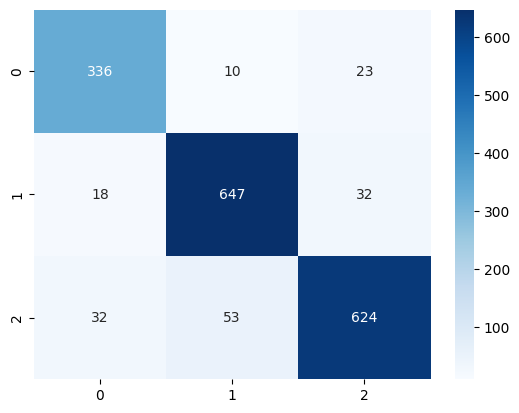

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
import pandas as pd
device='cuda'
data=data.to(device)
model.eval()
checkpoint_path = "best_model_interpolate.pth"
# checkpoint_path = "t5_checkpoint.pth"
checkpoint=torch.load(checkpoint_path)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
out = model(data.x, data.edge_index)
y_pred = out.argmax(dim=1)[data.val_mask].detach().cpu()
y = data.y.argmax(dim=1)[data.val_mask].detach().cpu()
result=f1_score(y, y_pred, average='micro')
vals.append(result)
print(f"F1 score: {result}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')
# dataset.create_test_json(model, 'pred_labels.json', device=device)

F1 score: 0.8980730223123732


<Axes: >

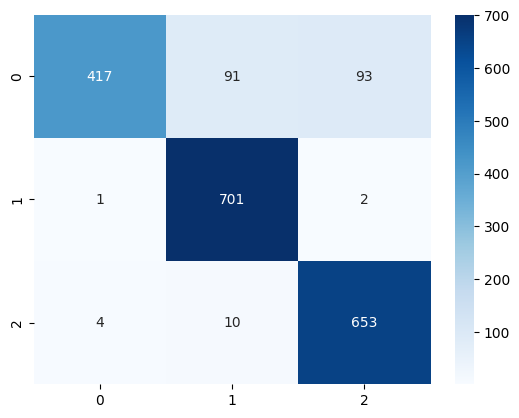

In [23]:
df=pd.read_csv('test_labels.csv')

id=np.array(df['nid'])

y_pred = out.argmax(dim=1)[id].to(device).detach().cpu()
y = data.y.argmax(dim=1)[id].detach().cpu()

result=f1_score(y, y_pred, average='micro')
tests.append(result)
print(f"F1 score: {result}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')



# Jumping knowledge




In [24]:
import torch
from torch_geometric.nn import GCNConv, MLP, JumpingKnowledge
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.jk = JumpingKnowledge(mode='cat')
        self.cls = MLP(in_channels=hidden_channels*2, out_channels=num_classes, num_layers=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x_1 = F.relu(x)
        x = self.conv2(x, edge_index)
        x_2 = F.relu(x)
        x = self.jk([x_1, x_2])
        x = self.cls(x)
        return x
model = GCN(dataset.num_node_features, 512, dataset.num_classes)

# Entrenar el modelo

In [25]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam,AdamW
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
# for i in range(len(data.train_mask)):
#     data.train_mask[i]=True
best=0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
optm_func = CrossEntropyLoss()

data = data.to(device)


neis = [25, 10]
train_loader = NeighborLoader(data, batch_size=256, num_neighbors=neis, input_nodes=data.train_mask, shuffle=True)
for epoch in range(300):
    model.train()
    for batch in train_loader:
            batch = batch.to(device)
            batch_size = batch.batch_size
            optimizer.zero_grad()
            out = model(batch.x,batch.edge_index)
            loss = optm_func(out[:batch_size], batch.y[:batch_size])
            loss.backward()
            optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1)[data.val_mask].detach().cpu()
    y = data.y.argmax(dim=1)[data.val_mask].detach().cpu()
    score=f1_score(y, y_pred, average='micro')
    if score>=best:
        best=score
        checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }
        torch.save(checkpoint, 'best_model_jumping.pth')


Epoch 0: Loss 0.5505422949790955
Epoch 50: Loss 0.23647195100784302
Epoch 100: Loss 0.2152480185031891
Epoch 150: Loss 0.1826351433992386
Epoch 200: Loss 0.10018038749694824
Epoch 250: Loss 0.06987616419792175


# Validación

/tmp/ipykernel_33717/1143262517.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint=torch.load(checkpoint_path)


F1 score: 0.8907042253521127


<Axes: >

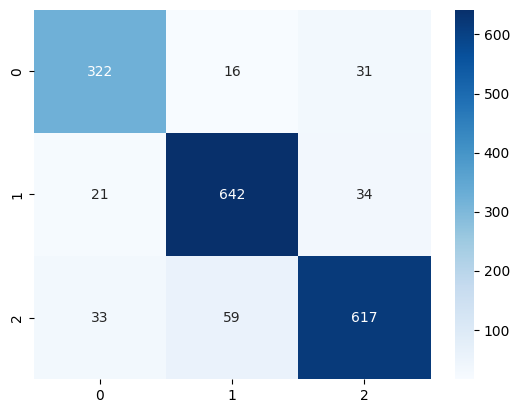

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
import pandas as pd
device='cuda'
data=data.to(device)
model.eval()
checkpoint_path = "best_model_jumping.pth"
# checkpoint_path = "t5_checkpoint.pth"
checkpoint=torch.load(checkpoint_path)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
out = model(data.x, data.edge_index)
y_pred = out.argmax(dim=1)[data.val_mask].detach().cpu()
y = data.y.argmax(dim=1)[data.val_mask].detach().cpu()
result=f1_score(y, y_pred, average='micro')
vals.append(result)
print(f"F1 score: {result}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')
# dataset.create_test_json(model, 'pred_labels.json', device=device)

F1 score: 0.8782961460446247


<Axes: >

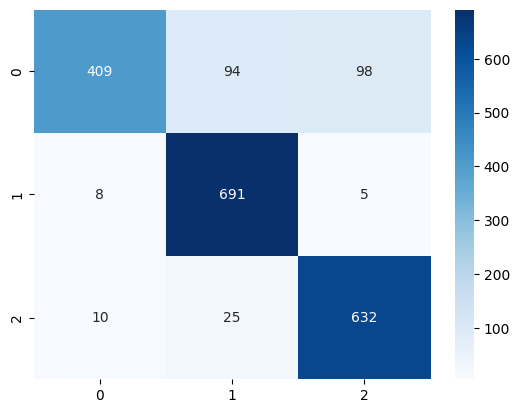

In [27]:
df=pd.read_csv('test_labels.csv')

id=np.array(df['nid'])

y_pred = out.argmax(dim=1)[id].to(device).detach().cpu()
y = data.y.argmax(dim=1)[id].detach().cpu()

result=f1_score(y, y_pred, average='micro')
tests.append(result)
print(f"F1 score: {result}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')



In [28]:
import matplotlib.pyplot as plt
vals=np.array(vals)
vals = np.trunc(vals * 10000) / 10000
tests=np.array(tests)
tests = np.trunc(tests * 10000) / 10000

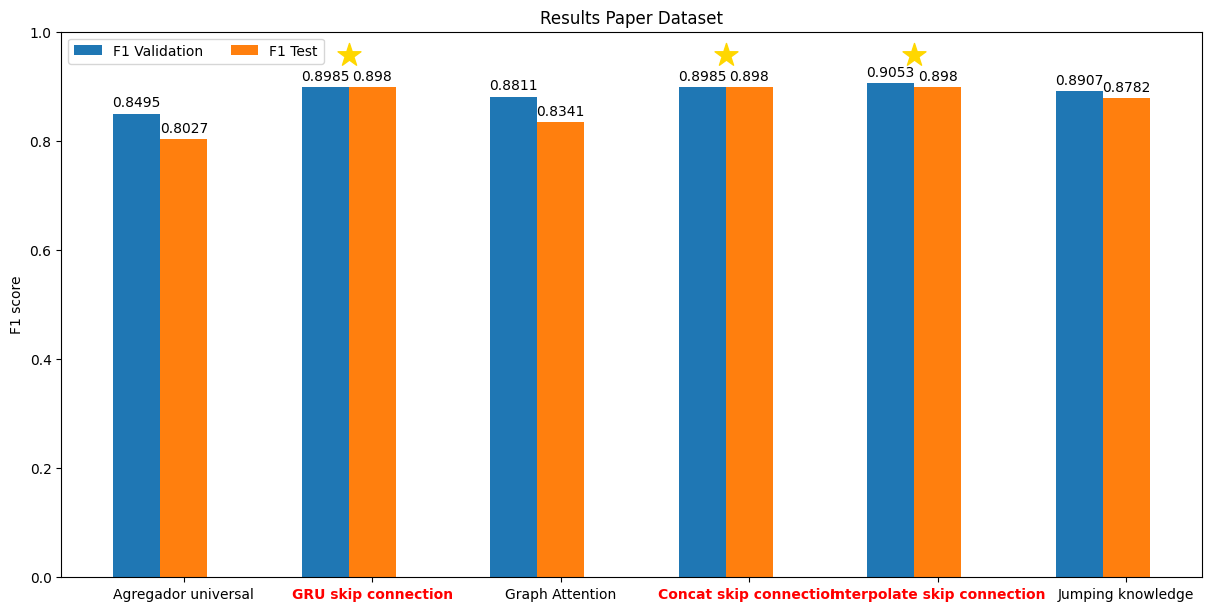

In [37]:
nets = ("Agregador universal", "GRU skip connection", "Graph Attention","Concat skip connection","Interpolate skip connection","Jumping knowledge")
results = {
    'F1 Validation': vals,
    'F1 Test': tests

}

x = np.arange(len(nets))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 6))


for attribute, measurement in results.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1 score')
ax.set_title('Results Paper Dataset')
ax.set_xticks(x + width, nets)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 1)

max_test_value = max(tests)
max_index = tests.argmax()

ax.scatter(x[max_index] + width / 2, max_test_value + 0.06, marker='*', color='gold', s=300, label='Highest F1 Test')


for label in ax.get_xticklabels():
    if label.get_text() == nets[max_index]:
        label.set_fontweight('bold')
        label.set_color('red')

plt.show()